In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler

Y_NAME = 'IsCanceled'
CSV_PATH = 'hotusa_cancellations.csv'

data = pd.read_csv(CSV_PATH, parse_dates=[
                   'ReservationStatusDate', 'ArrivalDate'])
data.drop(['Company', 'HotelId'], axis=1, inplace=True)


# Función de conversión de timestamp a senos y cosenos
def date_to_int(df, time_column):
    month = df[time_column].dt.month
    day = df[time_column].dt.day

    df[f'{ time_column }_m_sin'] = np.sin(2 * np.pi * month / 12)
    df[f'{ time_column }_m_cos'] = np.cos(2 * np.pi * month / 12)
    df[f'{ time_column }_d_sin'] = np.sin(2 * np.pi * day / 31)
    df[f'{ time_column }_d_cos'] = np.cos(2 * np.pi * day / 31)

    return df.drop(time_column, axis=1)

In [3]:
# División de la matriz
x = data.drop(Y_NAME, axis=1)
y = data[Y_NAME]

# Balanceo por submuestreo aleatorio de clase mayoritaria
sampler = RandomUnderSampler(sampling_strategy='majority')
x, y = sampler.fit_resample(x, y)
print(y.value_counts())

x = pd.get_dummies(x)
x = date_to_int(x, 'ReservationStatusDate')
x = date_to_int(x, 'ArrivalDate')

bool_vars = x.dtypes[x.dtypes == bool].index
x[bool_vars] = x[bool_vars].astype(int)

# Creación de los subconjuntos de entrenamiento y test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8)

IsCanceled
False    4750
True     4750
Name: count, dtype: int64


In [9]:
pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(alpha=0.001, learning_rate_init=0.001, max_iter=500)
)

pipeline.fit(xtrain, ytrain)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('mlpclassifier', MLPClassifier(alpha=0.001, max_iter=500))])

In [10]:
p = pipeline.predict(xtest)
cm = metrics.confusion_matrix(ytest, p)
tn, fp, fn, tp = cm.ravel()

print(f"""
TEST \n
Verdaderos positivos: { tp }
Verdaderos negativos: { tn }
Falsos positivos: { fp }
Falsos negativos: { fn }
Accuracy: { metrics.accuracy_score(ytest, p).round(4)}
""")

print(metrics.classification_report(ytest, p))


TEST 

Verdaderos positivos: 894
Verdaderos negativos: 975
Falsos positivos: 11
Falsos negativos: 20
Accuracy: 0.9837

              precision    recall  f1-score   support

       False       0.98      0.99      0.98       986
        True       0.99      0.98      0.98       914

    accuracy                           0.98      1900
   macro avg       0.98      0.98      0.98      1900
weighted avg       0.98      0.98      0.98      1900



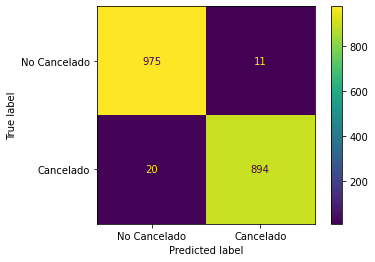

In [11]:
metrics.ConfusionMatrixDisplay(cm, display_labels=[
    'No Cancelado', 'Cancelado'
]).plot()